In [36]:
import torch

In [37]:

import torch.cuda
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060')

In [38]:
torch.__version__

'1.12.1+cu102'

In [39]:
import matplotlib.pyplot as plt

In [40]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    
DEVICE = "cuda"

Using device: cuda

NVIDIA GeForce RTX 2060
Memory Usage:
Allocated: 0.2 GB
Cached:    0.9 GB


In [41]:
def blend_triangles(multi_canvas):
    xz, yz, colors, triangles = multi_canvas.shape
    canvas = torch.zeros((xz, yz, 3))
    canvas = canvas.to(DEVICE)
    for i in range(triangles):
        triangle_canvas = multi_canvas[:,:,:,i]
        alpha = triangle_canvas[:,:,3].reshape(xz,yz,1)
        canvas = canvas * (1 - alpha) + triangle_canvas[:,:,:3] * alpha
    return canvas
    


def random_triangles(num_triangles, x_size, y_size):
    positions = torch.rand(num_triangles, 6)
    position_limits = torch.tensor([x_size, y_size, x_size, y_size, x_size, y_size])
    position_limits = torch.tile(position_limits, (num_triangles,)).reshape(num_triangles, 6)
    positions = positions * position_limits
    positions = positions.to(DEVICE)
    positions = positions.to(torch.float64)
    
    colors = torch.rand(num_triangles, 4)
    color_limits = torch.tensor([1, 1, 1, 1])
    color_limits = torch.tile(color_limits, (num_triangles,)).reshape(num_triangles, 4)
    colors = colors * color_limits
    colors = colors.to(DEVICE)
    colors = colors.to(torch.float64)
    
    
    return torch.tensor(positions, requires_grad=True), torch.tensor(colors, requires_grad=True)


def build_triangles(positions, colors):
    return torch.cat((positions, colors), dim=1)


def render_multicanvas(triangles, x_grid, y_grid, x_size, y_size):
    triangles_canvas = triangles[:, -4:].T
    t = triangles[:, :6]
    inside = inside_triangle(x_grid, y_grid, t[:, 0], t[:, 1], t[:, 2], t[:, 3], t[:, 4], t[:, 5]).reshape(x_size, y_size, 1,
                                                                                                -1) #FIXME: FEO!!!
    multi_canvas = triangles_canvas * inside

    return multi_canvas


def render_triangles(triangles, x_grid, y_grid, x_size, y_size):
    multi_canvas = render_multicanvas(triangles, x_grid, y_grid, x_size, y_size)
    canvas = blend_triangles(multi_canvas)

    return canvas 


def triangle_area(ax, ay, bx, by, cx, cy):
    abx = bx - ax
    aby = by - ay
    acx = cx - ax
    acy = cy - ay
    cp = abx * acy - aby * acx
    return torch.abs(cp) / 2


def inside_triangle(px, py, ax, ay, bx, by, cx, cy):
    orig = triangle_area(ax, ay, bx, by, cx, cy)
    p1 = triangle_area(px, py, bx, by, cx, cy)
    p2 = triangle_area(ax, ay, px, py, cx, cy)
    p3 = triangle_area(ax, ay, bx, by, px, py)
    epsilon = 1e-6
    area_diff = (p1 + p2 + p3) - orig
    return torch.special.expit((1 - area_diff))


def generate_meshgrid(num_triangles, x_size, y_size):
  cx, cy, _ = torch.meshgrid(torch.arange(0, x_size), torch.arange(0, y_size), torch.arange(num_triangles), indexing="ij")
  return cx.to(DEVICE), cy.to(DEVICE)


def show(render):
  plt.imshow(render.cpu().detach().numpy())

In [42]:
import scipy as sp

/tmp/ipykernel_171193/3113997507.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(positions, requires_grad=True), torch.tensor(colors, requires_grad=True)


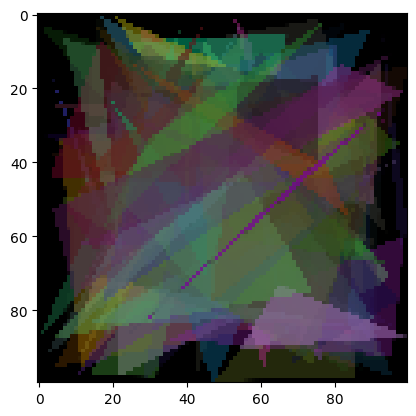

In [47]:
# test rendering
x_size = 100
y_size = 100
num_triangles = 100

triangles = build_triangles(*random_triangles(num_triangles, x_size, y_size))
x_grid, y_grid = generate_meshgrid(num_triangles, x_size, y_size)

render = render_triangles(triangles, x_grid, y_grid, x_size, y_size)

show(render)

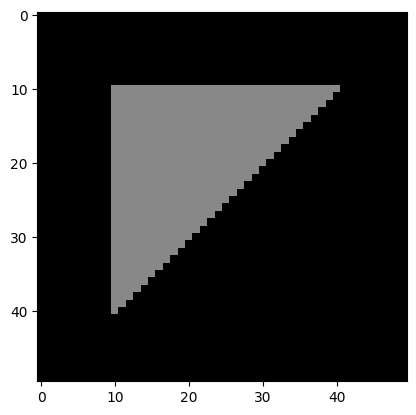

In [43]:
# test learning
x_size = 50
y_size = 50
num_triangles = 1

triangles = torch.Tensor([[10, 10, 10, 40, 40, 10, 1, 1, 1, 1]]).to(torch.float64).to(DEVICE)

x_grid, y_grid = generate_meshgrid(num_triangles, x_size, y_size)

target = render_triangles(triangles, x_grid, y_grid, x_size, y_size)

show(target)


In [ ]:
positions, colors = random_triangles(1, x_size, y_size)
optimizer = torch.optim.SGD([
                {'params': positions, 'lr': 0.1},
                {'params': colors, 'lr': 1e-3}
            ])
for t in range(1):
    # Forward pass: Compute predicted y by passing x to the model
    triangles = build_triangles(positions, colors)
    candidate = render_triangles(triangles, x_grid, y_grid, x_size, y_size)

    # Compute and print losstarget
    loss = torch.sum((target - candidate) ** 2)
    if t % 1000 == 99:
        print(t, loss.item())
        show(candidate)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
show(candidate)

In [ ]:
triangles.requires_grad

In [ ]:
import scipy
import cv2
from skimage.transform import rescale, downscale_local_mean

img = sp.misc.face()
scale = 0.2
width = int(img.shape[1] * scale)
height = int(img.shape[0] * scale)
dim = (width, height)
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

target = torch.Tensor(img).to(DEVICE) / 255
target.shape

In [ ]:
show(target)

In [ ]:
x_size, y_size = target.shape[:2]
target_t = torch.Tensor(target)
NUM_TRIANGLES = 50

x_grid, y_grid = generate_meshgrid(NUM_TRIANGLES, x_size, y_size)
positions, colors = random_triangles(NUM_TRIANGLES, x_size, y_size)

optimizer = torch.optim.SGD([
                {'params': positions, 'lr': 0.001},
                {'params': colors, 'lr': 0.00001}
            ])

try:
    for t in range(2000000):
        # Forward pass: Compute predicted y by passing x to the model
        triangles = build_triangles(positions, colors)
        candidate = render_triangles(triangles, x_grid, y_grid, x_size, y_size)

        # Compute and print losstarget
        loss = torch.sum((target - candidate) ** 2)
        if t % 10 == 0:
            print(t, loss.item())


        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
except KeyboardInterrupt:
     show(candidate)

In [ ]:
optimizer = torch.optim.SGD([
                {'params': positions, 'lr': 0.01},
                {'params': colors, 'lr': 0.00001}
    ])
for t in range(20000):
    # Forward pass: Compute predicted y by passing x to the model
    triangles = build_triangles(positions, colors)
    candidate = render_triangles(triangles, x_grid, y_grid, x_size, y_size)

    # Compute and print losstarget
    loss = torch.sum((target - candidate) ** 2)
    if t % 100 == 0:
        print(t, loss.item())
        show(candidate)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [26]:
import numpy as np
cx = np.array([[1, 2], [2, 3]])
cy = np.array([[3, 4], [1, 2]])

In [28]:
c = np.arange(30)
c = c.reshape((5, 6))

c

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29]])

In [29]:
c[cx, cy]

array([[ 9, 16],
       [13, 20]])

In [31]:
import triangulate

True NVIDIA GeForce RTX 2060
Using device: cuda

NVIDIA GeForce RTX 2060
Memory Usage:
Allocated: 0.2 GB
Cached:    0.9 GB


In [34]:
triangulate.generate_meshgrid(3,4,5)

(tensor([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],
 
         [[2, 2, 2],
          [2, 2, 2],
          [2, 2, 2],
          [2, 2, 2],
          [2, 2, 2]],
 
         [[3, 3, 3],
          [3, 3, 3],
          [3, 3, 3],
          [3, 3, 3],
          [3, 3, 3]]], device='cuda:0'),
 tensor([[[0, 0, 0],
          [1, 1, 1],
          [2, 2, 2],
          [3, 3, 3],
          [4, 4, 4]],
 
         [[0, 0, 0],
          [1, 1, 1],
          [2, 2, 2],
          [3, 3, 3],
          [4, 4, 4]],
 
         [[0, 0, 0],
          [1, 1, 1],
          [2, 2, 2],
          [3, 3, 3],
          [4, 4, 4]],
 
         [[0, 0, 0],
          [1, 1, 1],
          [2, 2, 2],
          [3, 3, 3],
          [4, 4, 4]]], device='cuda:0'))

In [35]:
_[0].shape

torch.Size([4, 5, 3])